<font size="4"> _Меня зовут Илья Баин._</font> 

<font size="4">_Я закончил нефтегазовый университет._ </font> 
    
<font size="4">_На выпускном курсе мной был разработан проект, про который сегодня пойдет речь._</font> 

<font size="5">__"Интерактивное приложение нахождения нагрузки бурильной колонны в любой точке с учетом коэффициента трения от проводимой операции"__</font> 

<font size="3">**Проблема**</font> 

<font size="3">Когда компания начинает бурение новой скважины, она должна определить оптимальную компоновку бурильной колонны - это набор инструментов, который используется для бурения скважины. Неправильно подобранная компоновка может привести к проблемам, таким как задержка бурения, ухудшение качества бурения, повреждение бурильных труб, а иногда и к полной потере скважины. Для того чтобы этого не произошло используются данные с предыдущих скважин для более точного прогнозирования оптимальной компоновки бурильной колонны и минимизации рисков возникновения проблем в процессе бурения. Анализ данных с предыдущих скважин может помочь определить, какие типы инструментов наиболее эффективны для конкретного типа геологической формации или месторождения нефти и газа. Это позволяет повысить эффективность бурения, снизить затраты и ускорить процесс разведки и добычи нефти и газа.</font> 

<font size="3">**Актуальность:**</font> 

<font size="3">Создание интуитивно понятных и доступных по стоимости цифровых инструментов может значительно упростить процесс проектирования и бурения скважин. Такие инструменты могут быть освоены в считанные минуты, что позволит инженерам быстрее приступить к работе и улучшить эффективность процесса.</font> 

<font size="3">**Задача:**</font> 

<font size="3">Создать простой и доступный инструмент для определения нагрузок на бурильную колонну по стволу скважины.</font> 

### 1. Импортирую нужные библиотеки

In [43]:
import numpy as np
import pandas as pd
import json
import plotly
import math
from IPython import get_ipython
from IPython.display import display
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import Accordion, IntSlider, Text
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

### 2. Создаю функцию, которая берёт данные инклинометрии скважины и находит следующие величины: изменение глубины, зенитного и азимутального угла, осевой нагрузки каждого элемента по глубине скважины. 

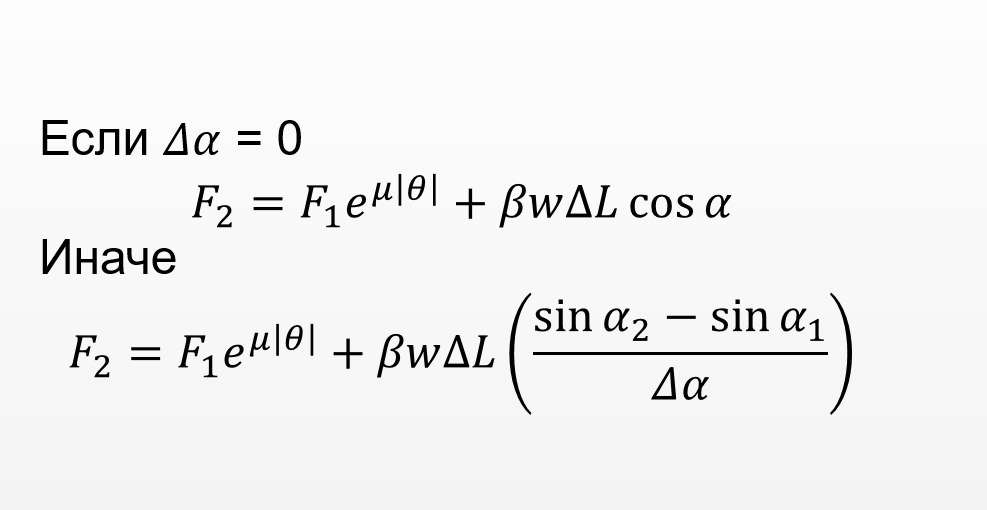
<font size="3">**F1 - усилие натяжения элемента, находящегося ниже**</font>

<font size="3">**F2 - усилие натяжения элемента, находящегося выше**</font> 

<font size="3">**θ -  понятие угла наклона, который зависит как от наклона ствола скважины, так и от азимута**</font>

<font size="3">**β - коэффициент плавучести**</font> 

<font size="3">**w - единица веса трубы**</font> 

<font size="3">**delta L - изменение длины**</font> 

<font size="3">**Ню - коэффициент трения**</font> 

<font size="3">**Альфа - азимутальный угол**</font> 

In [44]:
def Loads(f,G):
    
    # Загружать данные
    df_excel = pd.read_excel(r"C:\Users\ilya_\Downloads\ВУ_ОНГКМ_1333_к1609_Траектория_V4привязка_к_ГИС_ЭК_06_08_2020_1.xlsx")
    
    # Оставляем столбцы, которые необходимы для расчетов
    df = df_excel.loc[13:].reset_index(drop=True).rename(columns=df_excel.loc[12])
    df = df[['Глубина по стволу, м','Зенитный угол, град','Азимут картогр, Grid, град','Глубина по вертикали, м','С-Ю, м','В-З,м','Пространст. интенсивность, град/10 м']]
    
    # Изменение длины (дельта L)
    df["shift_L"] = df["Глубина по стволу, м"].shift(-1).fillna(0)
    df["delta_L"] = df['shift_L'] - df['Глубина по стволу, м']

    # Перевод зенита и азимута в радианы
    df["Alpha"] = df["Зенитный угол, град"].apply(math.radians)
    df["Phi"] = df["Азимут картогр, Grid, град"].apply(math.radians)

    # Приращение альфы
    df["shift_alpha"] = df["Alpha"].shift(-1).fillna(0)
    df["delta_alpha"] = df['shift_alpha'] - df['Alpha']

    # Среднее значение ближайших альфа 
    df["Avg_alpha"] = (df['shift_alpha'] + df['Alpha'])/2

    # Дельта фи
    df["shift_phi"] = df["Phi"].shift(-1).fillna(0)
    df["delta_phi"] = df['shift_phi'] - df['Phi']

    # Мяу и Бета 
    df["MIU"] = f
    df["Beta"] = 0.87

    # Погонный вес
    df["w"] = 26
    df["w"] = df["w"].apply(float)

    # Косинус альфа и синус альфа
    df['cos_alpha'] = df["Alpha"].apply(math.cos)
    df["sin_alpha"] = df["Alpha"].apply(math.sin)
    df["sin_shift"] = df["sin_alpha"].shift(-1).fillna(0)
    df["sin_dif_alpha"] = df['sin_shift'] - df['sin_alpha']
    df["sin_avr_alpha"] = df["Avg_alpha"].apply(math.sin)

    for i in range(len(df)):
        if df.loc[len(df)-1-i,"sin_dif_alpha"]<0:
            df.loc[len(df)-1-i,"sin_dif_alpha"] = 0

    # Находим коэффициент К
    df["K"] = ((df["delta_alpha"]/df["delta_L"])**2+(df["delta_phi"]/df["delta_L"])**2*(df["sin_avr_alpha"])**2)**0.5
    
    # Вносим столбец с нулевым значением F
    df['F'] = 0
    
    # Расчитываем Тета
    df['Teta'] = df["delta_L"]*df["K"]
    
    # Считаем экспоненту 
    df['for_exp'] = df["Teta"]*df["MIU"]
    df['exp'] =  df["for_exp"].apply(math.exp).fillna(0)

    # Осевая нагрузка
    for i in range(len(df)-1):
        if int(df.loc[len(df)-1-i,"delta_alpha"])==0:
            df.loc[len(df)-2-i,"F"] = df.loc[len(df)-1-i,"F"]*df.loc[len(df)-1-i,"exp"] + df.loc[len(df)-1-i,"Beta"]*df.loc[len(df)-1-i,"w"]*df.loc[len(df)-1-i,"delta_L"]*df.loc[len(df)-1-i,"cos_alpha"]
        else:
            df.loc[len(df)-2-i,"F"] = df.loc[len(df)-1-i,"F"]*df.loc[len(df)-1-i,"exp"] + df.loc[len(df)-1-i,"Beta"]*df.loc[len(df)-1-i,"w"]*df.loc[len(df)-1-i,"delta_L"]*(df.loc[len(df)-1-i,"sin_dif_alpha"]/df.loc[len(df)-1-i,"delta_alpha"])
    df['ff'] = np.linspace(max(df['F']),0,len(df))
    df['Difference'] = df['F'] - df['ff']
    df_load = df[['Глубина по стволу, м','Зенитный угол, град','Азимут картогр, Grid, град','Глубина по вертикали, м','С-Ю, м','В-З,м','Пространст. интенсивность, град/10 м','F','Difference']]
    df_load["F"] = df_load["F"].apply(lambda x:x-G*1000) 
    return df_load.copy()

### 3. Вводим операции, которые встречаются при работе, с добавочным коэффициентом трения.

<font size="3"> 
    
**В случае спуска**, трение будет направлено против движения, поэтому коэффициент трения будет отрицательным.
    
**При подъеме**, трение будет направлено в сторону движения, поэтому коэффициент трения будет положительным.

**При бурении**, добавление нагрузки на долото может изменить распределение сил и повлиять на коэффициент трения. Возможно, что нагрузка на долото уменьшит вес на крюке и, следовательно, уменьшит коэффициент трения.

**При проработке** ствола скважины, коэффициент трения будет зависеть от типа грунта или породы, с которыми контактирует долото. Если грунт или порода имеют высокий коэффициент трения, то трение будет большим.

**При промывке**, коэффициент трения может быть небольшим, так как используется жидкость для смазки и снижения трения между долотом и стенками скважины.

В целом, каждая операция имеет свои особенности и влияет на коэффициент трения в разной степени.</font> 

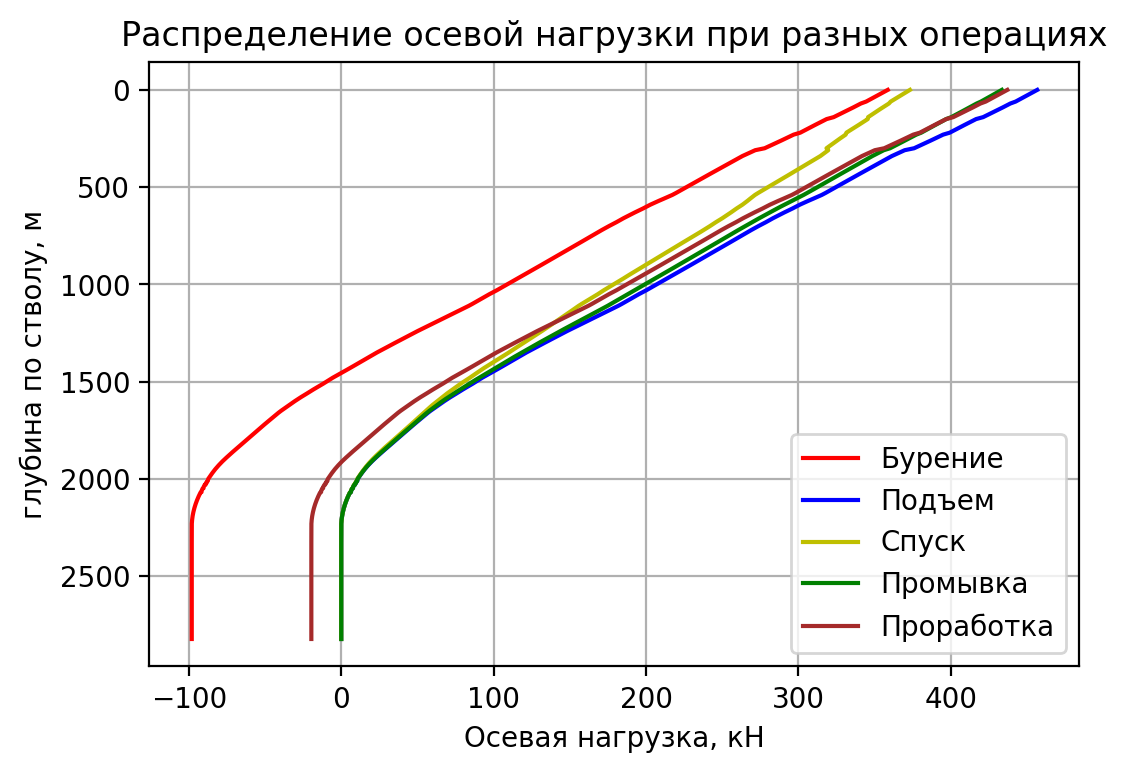

In [45]:
operations = [["Бурение",0.1,10],["Подъем",0.1,0],["Спуск",-0.1,0],["Промывка",0.05,0],["Проработка",0.1,2],]
colours = ["r","b","y","g","brown"]
fig = plt.figure(dpi = 200)
ax = fig.add_subplot(111)
for l,i in enumerate(operations):
    df_load = Loads(i[1],i[2])
    df_load["F"] = df_load["F"]*9.81/1000
    ax.plot(df_load["F"],df_load["Глубина по стволу, м"], label = i[0],color = colours[l] )
    
    # Оформление графика 
    ax.invert_yaxis()
    ax.legend(loc = 'lower right')
    ax.set_xlabel('Осевая нагрузка, кН')
    ax.set_ylabel('глубина по стволу, м')
    ax.set_title("Распределение осевой нагрузки при разных операциях")
    ax.grid()

<font size="3"> 
    
Взглянув на график, мы можем увидеть, как распределяется осевая нагрузка при разных операциях. 

**Самая большая - при подъеме колонны.**</font> 

### 4. Строю траекторию ствола скважины. Создаю маркер, который будет определять местоположение. Ввожу список возможных операций в скважине. Соединяю в один механизм.

In [47]:
# Ползунок для определения глубины
slider = ipywidgets.IntSlider(value=0,
                              min=0,
                              max=max(df['Глубина по вертикали, м'].tolist()),
                              step=1,
                              description='Глубина:',
                              disabled=False,
                              continuous_update=False,
                              orientation='horizontal',
                              readout=True,
                              readout_format='d')

# Построение траектории
def intA(trajectory):
    global df
    xp = df['Глубина по вертикали, м'].tolist()
    
    fp = df['С-Ю, м'].tolist()
    
    sp = df['В-З,м'].tolist()
    
    F = df['F'].tolist()
    
    Int = df['Пространст. интенсивность, град/10 м'].tolist()
    Dif = df['Difference'].tolist()
    
    a = np.interp(trajectory, xp, fp)
    
    b = np.interp(trajectory, xp, sp)
    
    c = np.interp(trajectory, xp, F)
    
    d = np.interp(trajectory, xp, Int)
    
    e = np.interp(trajectory, xp, Dif)
    
#   return print(' С-Ю,м:',a,'\n','\n','В-З,м:',b,'\n','\n','F,H:',c,'\n','Разница с реальным весом:',e,'\n','\n','Пространст. интенсивность, град/10 м:',d)
    print('Осевая нагрузка, F:',round(c/101.971621,1),'кН','\n','\n','Пространст. интенсивность, град/10 м:',round(d,1))
qw = "Спуск"
global qw

# Маркер
def red_point(trajectory):
    global df
    xp = df['Глубина по вертикали, м'].tolist()
    fp = df['С-Ю, м'].tolist()
    sp = df['В-З,м'].tolist()
    
    a = np.interp(trajectory, xp, fp)
    b = np.interp(trajectory, xp, sp)
    c = np.interp(trajectory + 1, xp, fp)
    d = np.interp(trajectory + 1, xp, sp)
    e = np.interp(trajectory + 2, xp, fp)
    g = np.interp(trajectory + 2, xp, sp)
    fig = plt.figure(figsize=(12,8))
    ax_3d = fig.add_subplot(projection='3d')
    ax_3d.set_xlabel('С-Ю', fontsize = 10)
    ax_3d.set_ylabel('В-З', fontsize = 10)
    ax_3d.set_zlabel('Глубина по вертикали, м', fontsize = 10)
    ax_3d.set_title("Траектория ствола скважины", fontsize = 15)
    ax_3d.plot(fp,sp,xp,linewidth=2, color='blue')
    ax_3d.invert_zaxis()
    ax_3d.plot([a,c,e],[b,d,g],[trajectory,trajectory + 1,trajectory + 2],linewidth=6, color='red')
    print(qw)
    plt.show()
    
# Операции, проводимые в скважине    
def f(operation):
    global df
    global qw
    qw=operation
    
    if operation=="Спуск":
        print("коэффициент трения  μ = -0.1")
        df = Loads(-0.1,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
    if operation=="Подъем":
        print("коэффициент трения  μ = 0.1")
        df = Loads(0.1,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Бурение":
        print("коэффициент трения  μ = 0.1\nнагрузка на долото G = 100 кН")
        df = Loads(0.1,10)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Проработка":
        print("коэффициент трения  μ = 0.1\nнагрузка на долото G = 20 кН")
        df = Loads(0.1,2)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
    if operation == "Промывка":
        print("коэффициент трения  μ = 0.05")
        df = Loads(0.05,0)
        ipywidgets.interact(red_point,trajectory=slider)
        ipywidgets.interact(intA, trajectory=slider)
        
interact(f, operation=["Спуск",'Подъем','Бурение',"Проработка","Промывка"])



interactive(children=(Dropdown(description='operation', options=('Спуск', 'Подъем', 'Бурение', 'Проработка', '…

<function __main__.f(operation)>

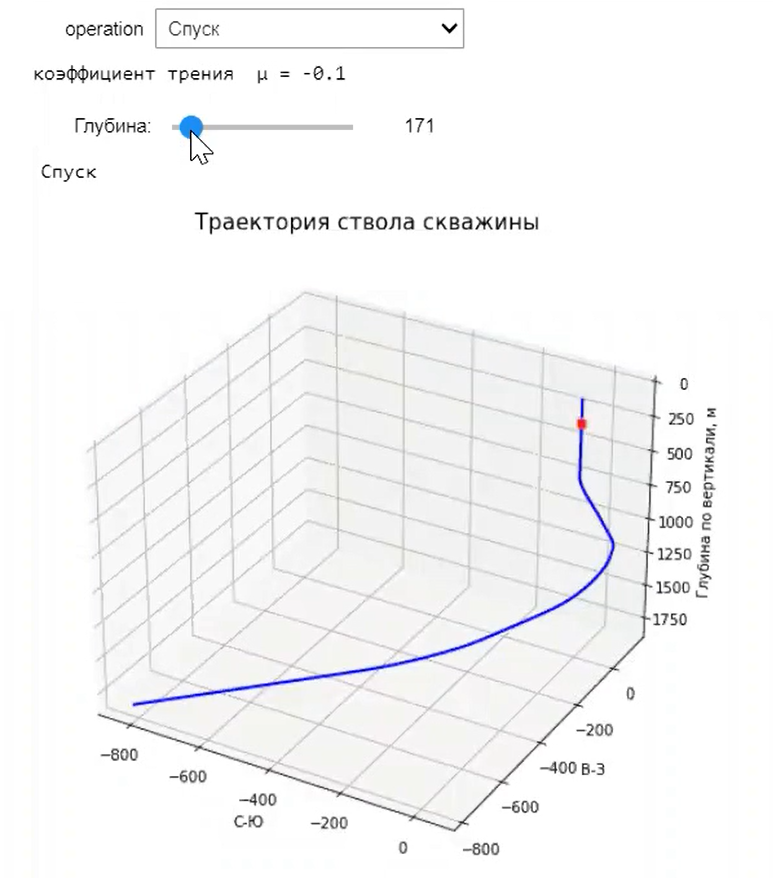

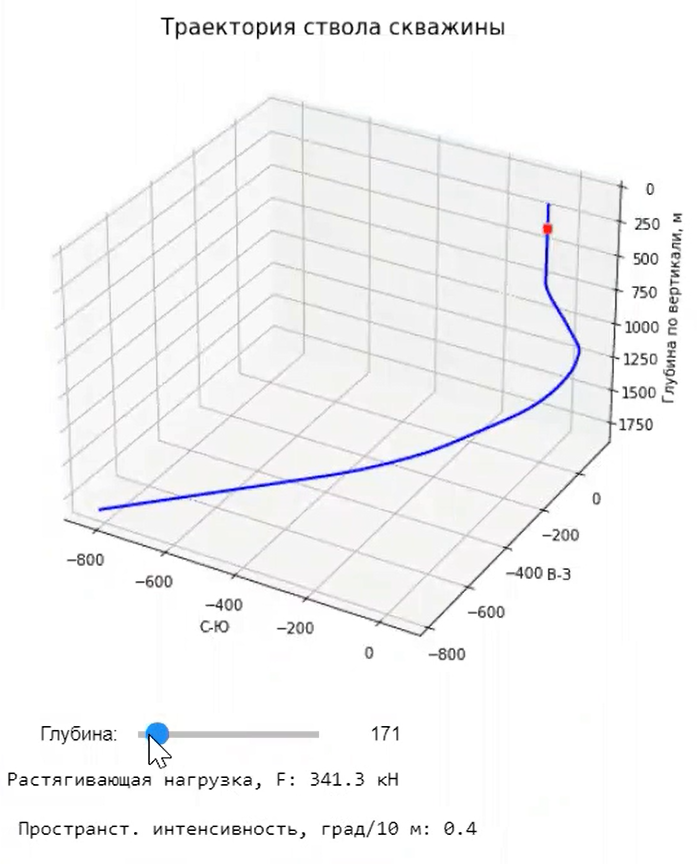

<font size="3">
Для примера возьмем две разные операции на одной и той же глубине и увидим разницу в значении.
</font>

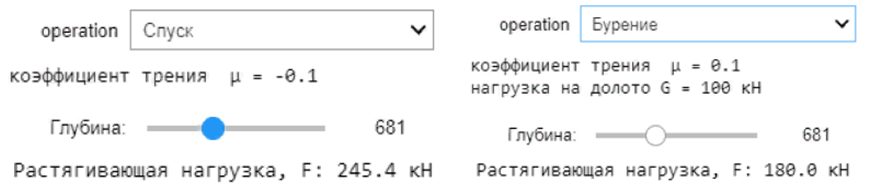

<font size="3">**Заключение:**</font> 

<font size="3"> Инструмент может использоваться для исследований различных компоновок низа бурильной колонны, определения наилучшей компоновки на основе анализа нагрузок с предыдущих скважин.</font> 